<a href="https://colab.research.google.com/github/mirchandani-mohnish/ClusterMetrics/blob/main/Density_Based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from sklearn import datasets
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score, mutual_info_score
from sklearn.preprocessing import StandardScaler
import time
from sklearn.decomposition import PCA
import heapq
from scipy.spatial.distance import euclidean
from sklearn.cluster import DBSCAN
import kagglehub
from sklearn.preprocessing import LabelEncoder

In [2]:
seed = 0

In [17]:

def print_metrics(X, true_labels_values, predicted_labels):
    print("-------------------------------------------------------------------")
    true_labels = LabelEncoder().fit_transform(true_labels_values)
    # Silhouette Score
    try:
        print(f"Silhouette score: {silhouette_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Silhouette score failed: {str(e)}")

    # Adjusted Rand Score
    try:
        print(f"Adjusted Rand score: {adjusted_rand_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Adjusted Rand score failed: {str(e)}")

    # Calinski-Harabasz Score
    try:
        print(f"Calinski-Harabasz score: {calinski_harabasz_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Calinski-Harabasz score failed: {str(e)}")

    # Davies-Bouldin Score
    try:
        print(f"Davies-Bouldin score: {davies_bouldin_score(X, predicted_labels):.4f}")
    except Exception as e:
        print(f"Davies-Bouldin score failed: {str(e)}")

    # Mutual Information Score
    try:
        print(f"Mutual Information score: {mutual_info_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Mutual Information score failed: {str(e)}")


# DBSCAN


In [4]:
import pdb
import sys

def dbscan_base(df, eps, MinPts):
    # Extract the features (excluding the target)
    # D = df.drop(['target', 'species', 'dbscan_predictions'], axis=1).values
    D = df
    # Mark all points as unvisited
    n = len(D)
    visited = [False] * n
    clusters = []
    noise = []




    for i in range(n):
        if not visited[i]:
            visited[i] = True
            neighbors = region_query(D, i, eps)

            if len(neighbors) < MinPts:
                noise.append(i)
            else:
                cluster = []
                expand_cluster(D, i, neighbors, cluster, eps, MinPts, visited)
                clusters.append(cluster)


    cluster_labels = generate_cluster_labels(D, clusters, noise)
    print(clusters)
    return clusters, noise, cluster_labels

def expand_cluster(D, P, neighbors, cluster, eps, MinPts, visited):
    cluster.append(P)
    i = 0
    while i < len(neighbors):
        Q = neighbors[i]
        if not visited[Q]:
            visited[Q] = True
            Q_neighbors = region_query(D, Q, eps)
            if len(Q_neighbors) >= MinPts:
                neighbors += Q_neighbors
        if Q not in cluster:
            cluster.append(Q)
        i += 1

def region_query(D, P, eps):
    neighbors = []
    for i in range(len(D)):
        if euclidean(D[P], D[i]) < eps:
            neighbors.append(i)
    return neighbors

def generate_cluster_labels(D, clusters, noise):
    cluster_labels = np.full(len(D), -1)
    print(len(cluster_labels))
    for i in range(0,len(clusters)):
        for x in clusters[i]:
            cluster_labels[x] = i

    for x in noise:
        cluster_labels[x] = -1

    return cluster_labels




In [5]:
def percentage_similarity(base_array, sklearn_array):
    # Ensure both arrays have the same shape
    if base_array.shape != sklearn_array.shape:
        raise ValueError("Input arrays must have the same shape")
    cnt_sim = 0
    for i,x in enumerate(base_array):
      if x == sklearn_array[i]:
        cnt_sim += 1
    return cnt_sim * 100/ len(base_array)


## Iris Dataset

In [20]:
path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
iris = pd.read_csv(os.path.join(path, "iris.csv"))
iris = iris.dropna()

iris_filtered = iris.select_dtypes(include=['float64'])

X_iris = iris_filtered.to_numpy()


start_time = time.time()
cluters, noise, labels_base_iris = dbscan_base(X_iris, 0.5, 5)
print(labels_base_iris)
print(f"Execution time (base): {time.time() - start_time} seconds")
# print(f"Silhouette score (base): {silhouette_score(X_iris, labels_base_iris)}")
print_metrics(X_iris, iris['species'], labels_base_iris)

start_time = time.time()
dbscan_iris = DBSCAN().fit(X_iris)

labels_sklearn_iris = dbscan_iris.labels_
print(labels_sklearn_iris)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_iris, iris['species'], labels_sklearn_iris)
print(f"percentage_similarity: {percentage_similarity(labels_base_iris, labels_sklearn_iris)}%")

150
[[0, 4, 7, 9, 10, 11, 17, 19, 20, 21, 23, 26, 27, 28, 31, 34, 35, 36, 37, 39, 40, 43, 46, 48, 49, 6, 1, 2, 12, 24, 25, 29, 30, 45, 47, 3, 5, 16, 18, 32, 44, 22, 38, 42, 8, 13, 33, 14, 15], [50, 52, 65, 76, 86, 77, 51, 54, 58, 74, 75, 56, 110, 147, 63, 85, 91, 97, 72, 123, 126, 71, 78, 70, 127, 138, 115, 116, 137, 145, 103, 111, 112, 128, 132, 139, 55, 73, 83, 133, 61, 119, 146, 149, 67, 82, 92, 95, 96, 99, 66, 101, 142, 136, 140, 148, 141, 104, 120, 124, 143, 84, 88, 90, 94, 121, 69, 89, 64, 79, 80, 53, 62, 113, 100, 144, 102, 114, 81, 59, 125, 130, 107, 129]]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1
  1  1 -1  1  1  1  1  1  1 -1 -1  1 -1 -1  1  1  1  1  1  1  1 -1 -1  1
  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1 

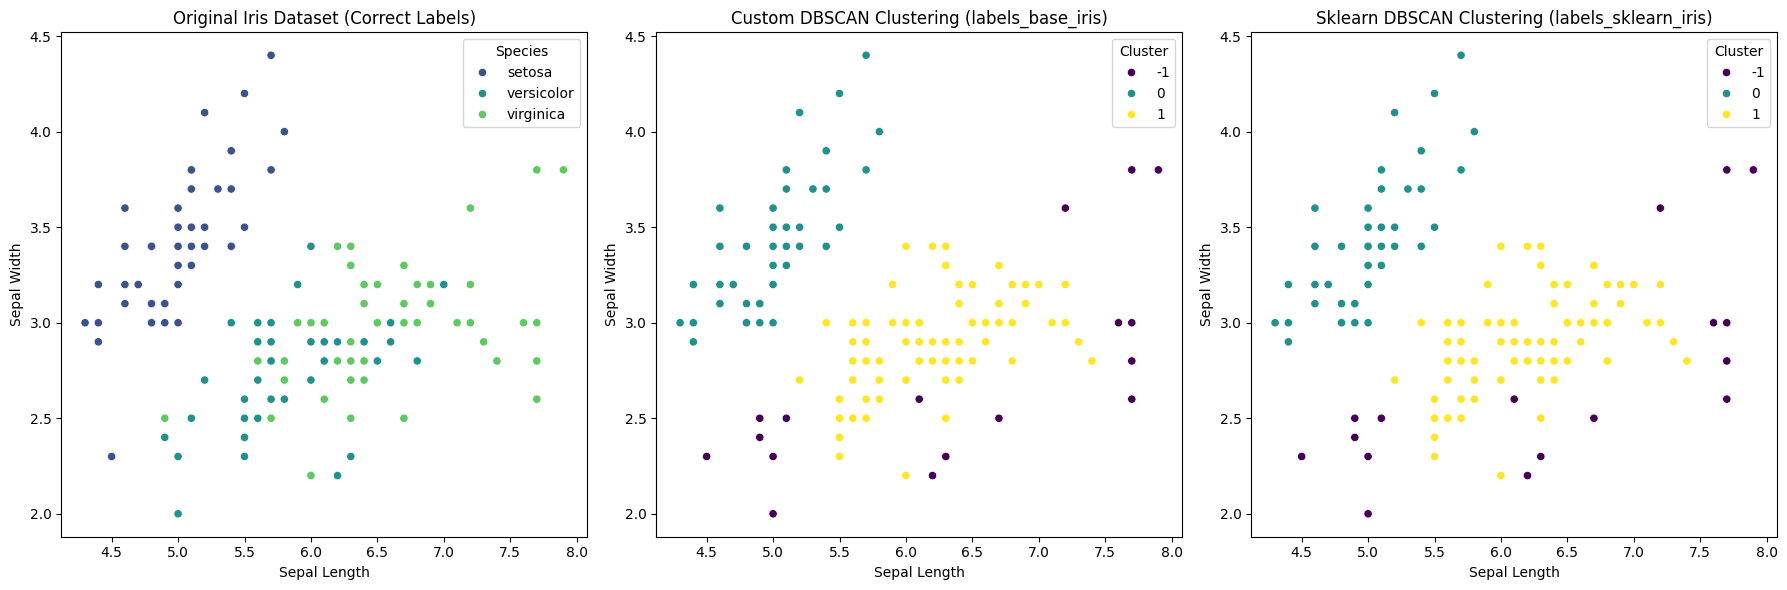

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="viridis", ax=axes[0])
axes[0].set_title("Original Iris Dataset (Correct Labels)")
axes[0].set_xlabel("Sepal Length")
axes[0].set_ylabel("Sepal Width")
axes[0].legend(title="Species")

# Plot 2: Custom DBSCAN Labels (labels_base_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_base_iris, palette="viridis", ax=axes[1])
axes[1].set_title("Custom DBSCAN Clustering (labels_base_iris)")
axes[1].set_xlabel("Sepal Length")
axes[1].set_ylabel("Sepal Width")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_sklearn_iris, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn DBSCAN Clustering (labels_sklearn_iris)")
axes[2].set_xlabel("Sepal Length")
axes[2].set_ylabel("Sepal Width")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## AI Dataset


In [21]:
path = kagglehub.dataset_download("katerynameleshenko/ai-index")
ai = pd.read_csv(os.path.join(path, "AI_index_db.csv"))
ai = ai.dropna()

ai["Total_score_Category"] = pd.cut(
    ai["Total score"],
    bins=[-float("inf"), 17.03, 26.91, float("inf")],
    labels=["Low", "Medium", "High"]
)
ai = ai.drop(columns=["Total score"])

ai_filtered = ai.select_dtypes(include=['float64'])

X_ai = ai_filtered.to_numpy()
k_ai = 3

scalar = StandardScaler()
X_ai = scalar.fit_transform(X_ai)

print("AI Global Index")

start_time = time.time()
# labels_base_ai, centroids_base_ai = k_means(X_ai, k_ai)
cluters, noise, labels_base_ai = dbscan_base(X_ai, 0.5, 5)

print(labels_base_ai)
print(f"Execution time (base): {time.time() - start_time} seconds")
# print(f"Silhouette score (base): {silhouette_score(X_ai, labels_base_ai)}")
print_metrics(X_ai, ai['Total_score_Category'], labels_base_ai)
start_time = time.time()


dbscan_ai = DBSCAN().fit(X_ai)

labels_sklearn_ai = dbscan_ai.labels_
print(labels_sklearn_ai)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_ai, ai['Total_score_Category'], labels_sklearn_ai)
print(f"percentage_similarity: {percentage_similarity(labels_base_ai, labels_sklearn_ai)}%")

100%|██████████| 2.38k/2.38k [00:00<00:00, 3.10MB/s]

Extracting files...
AI Global Index
62
[]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Execution time (base): 0.1147756576538086 seconds
-------------------------------------------------------------------
Silhouette score failed: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Adjusted Rand score: 0.0000
Calinski-Harabasz score failed: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Davies-Bouldin score failed: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Mutual Information score: 0.0000
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]

Execution time (sklearn): 0.00588226318359375 seconds
---------------------------------------------

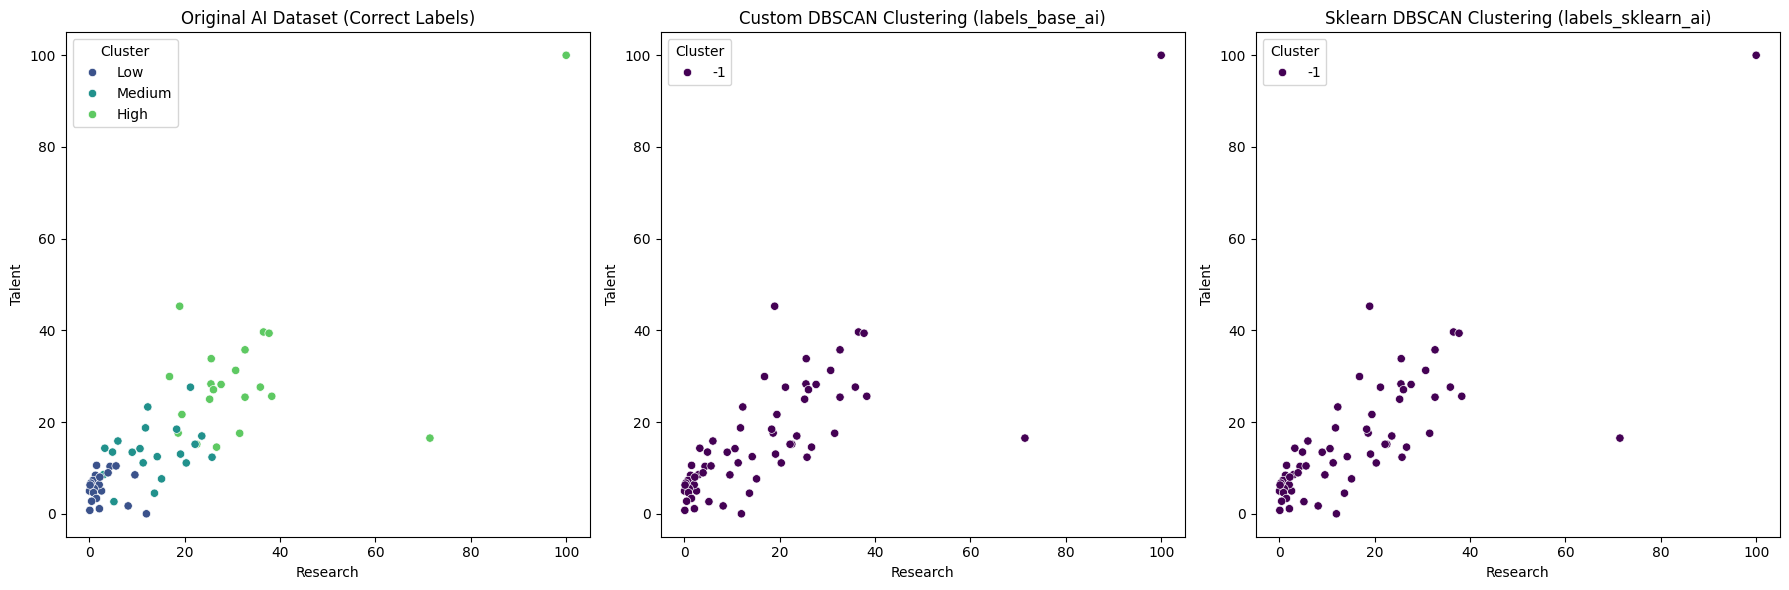

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[0])
axes[0].set_title("Original AI Dataset (Correct Labels)")
axes[0].set_xlabel("Research")
axes[0].set_ylabel("Talent")
axes[0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai, palette="viridis", ax=axes[1])
axes[1].set_title("Custom DBSCAN Clustering (labels_base_ai)")
axes[1].set_xlabel("Research")
axes[1].set_ylabel("Talent")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn DBSCAN Clustering (labels_sklearn_ai)")
axes[2].set_xlabel("Research")
axes[2].set_ylabel("Talent")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Earthquakes Dataset

In [23]:
path = kagglehub.dataset_download("shreyasur965/recent-earthquakes")
earthquakes = pd.read_csv(os.path.join(path, "earthquakes.csv"))

earthquakes = earthquakes.drop(columns=["time", "updated", "timezone", "latitude", "longitude", "tsunami", "nst", "dmin", "gap", "distanceKM", "postcode"])
earthquakes_filtered = earthquakes.select_dtypes(include=['float64', 'int64'])

X_earth = earthquakes_filtered.to_numpy()
# k_earth = 4

print("Global Earthquake Data")

start_time = time.time()
# labels_base_earth, centroids_base_earth = k_means(X_earth, k_earth)
cluters, noise, labels_base_earth = dbscan_base(X_earth, 0.5, 5)
print(labels_base_earth)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes['alert'], labels_base_earth)

start_time = time.time()
# kmeans_earth = KMeans(n_clusters=k_earth, random_state=seed).fit(X_earth)

dbscan_earth = DBSCAN().fit(X_earth)

labels_sklearn_earth = dbscan_earth.labels_
print(labels_sklearn_earth)
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes['alert'], labels_sklearn_earth)

100%|██████████| 214k/214k [00:00<00:00, 62.2MB/s]

Extracting files...
Global Earthquake Data


1137
[[29, 68, 379, 394, 417, 626, 835, 850, 875], [32, 67, 382, 393, 449, 593, 625, 838, 849, 903, 430, 888, 450, 904, 457, 910], [69, 94, 395, 413, 627, 651, 851, 871], [93, 412, 433, 650, 870, 891], [95, 414, 420, 652, 872, 878], [108, 109, 487, 492, 1128, 1133], [148, 195, 198, 509, 540, 543, 774, 805, 808, 976, 1020, 1023], [177, 179, 522, 524, 787, 789, 1005, 1007], [190, 196, 214, 535, 541, 559, 800, 806, 824, 1015, 1021, 1038, 1099], [193, 194, 538, 539, 803, 804, 1018, 1019], [202, 547, 812, 1027, 1103]]
[-1 -1 -1 ... -1 -1 -1]
Execution time (base): 12.794138431549072 seconds
-------------------------------------------------------------------
Silhouette score: -0.6976
Adjusted Rand score: 0.0331
Calinski-Harabasz score: 0.0587
Davies-Bouldin score: 1.7800
Mutual Information score: 0.0816
[-1 -1 -1 ... -1 -1 -1]

Execution time (sklearn): 0.013974428176879883 seconds
-------------------------------------------------------------------
Silhouette score: -0.6976
Adjusted Rand sco

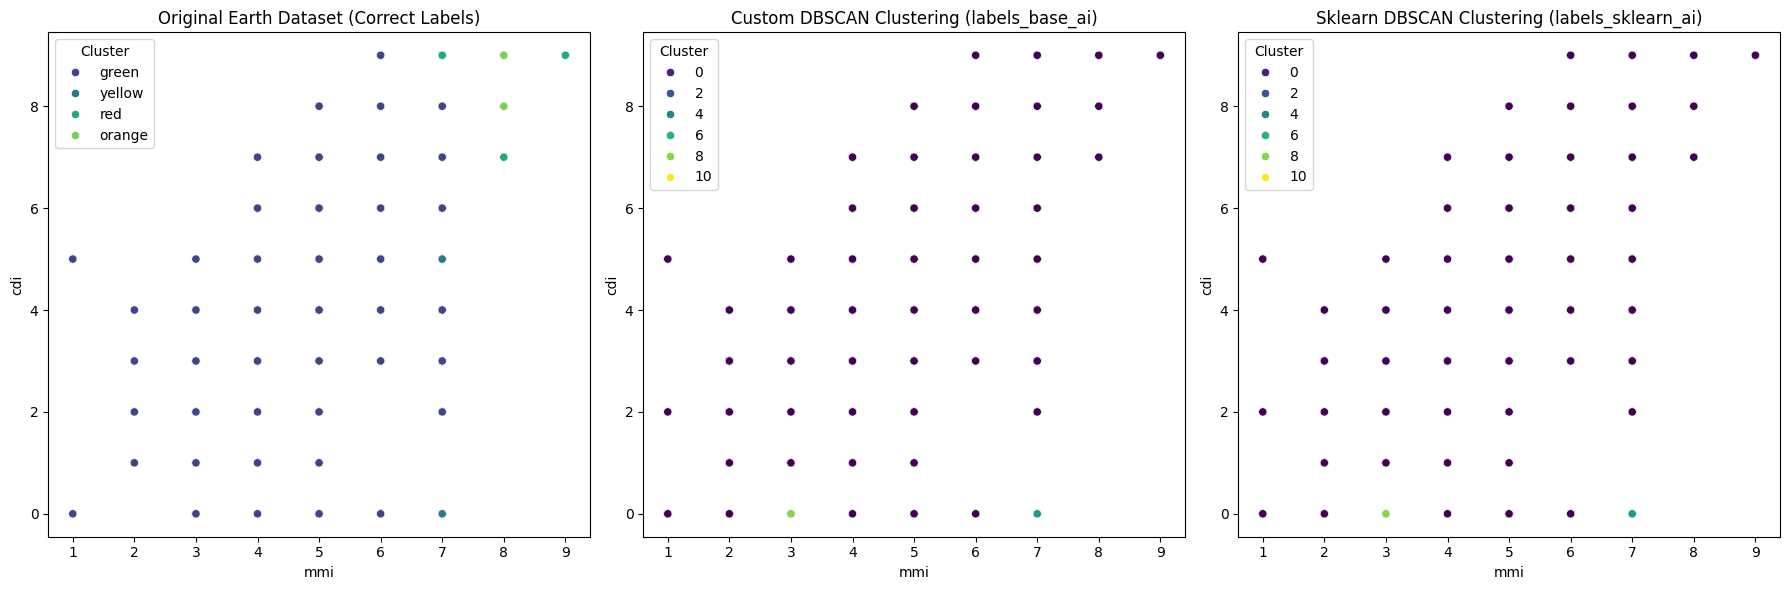

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette="viridis", ax=axes[0])
axes[0].set_title("Original Earth Dataset (Correct Labels)")
axes[0].set_xlabel("mmi")
axes[0].set_ylabel("cdi")
axes[0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_base_earth, palette="viridis", ax=axes[1])
axes[1].set_title("Custom DBSCAN Clustering (labels_base_ai)")
axes[1].set_xlabel("mmi")
axes[1].set_ylabel("cdi")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_sklearn_earth, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn DBSCAN Clustering (labels_sklearn_ai)")
axes[2].set_xlabel("mmi")
axes[2].set_ylabel("cdi")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

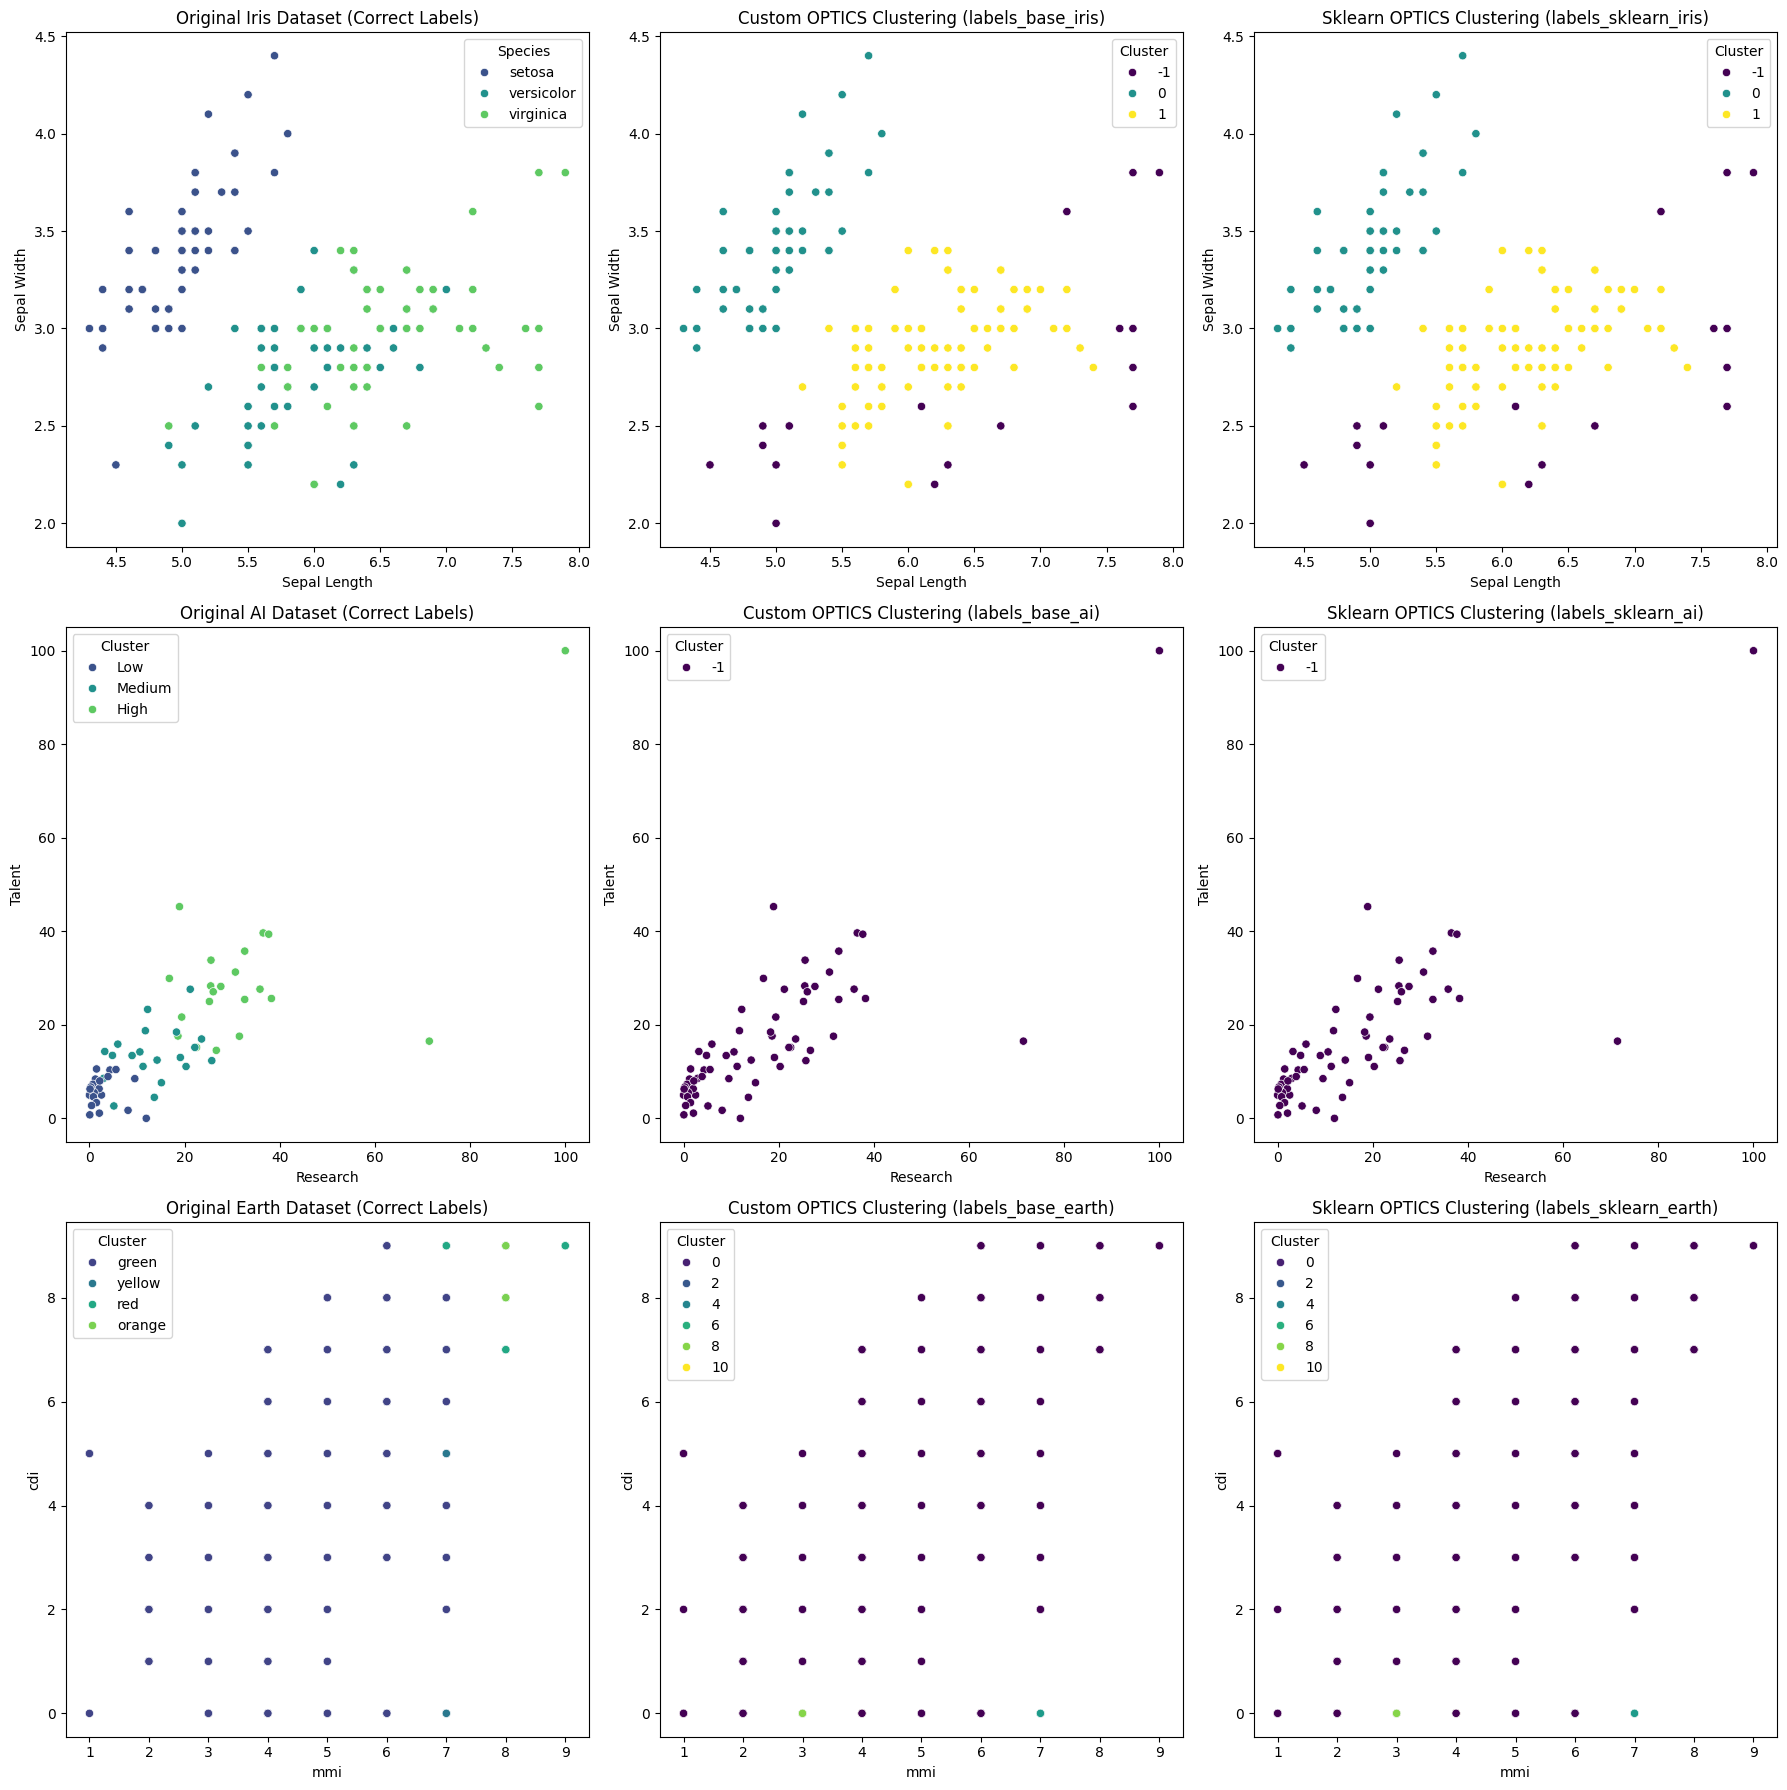

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="viridis", ax=axes[0][0])
axes[0][0].set_title("Original Iris Dataset (Correct Labels)")
axes[0][0].set_xlabel("Sepal Length")
axes[0][0].set_ylabel("Sepal Width")
axes[0][0].legend(title="Species")

# Plot 2: Custom DBSCAN Labels (labels_base_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_base_iris, palette="viridis", ax=axes[0][1])
axes[0][1].set_title("Custom OPTICS Clustering (labels_base_iris)")
axes[0][1].set_xlabel("Sepal Length")
axes[0][1].set_ylabel("Sepal Width")
axes[0][1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_sklearn_iris, palette="viridis", ax=axes[0][2])
axes[0][2].set_title("Sklearn OPTICS Clustering (labels_sklearn_iris)")
axes[0][2].set_xlabel("Sepal Length")
axes[0][2].set_ylabel("Sepal Width")
axes[0][2].legend(title="Cluster")

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[1][0])
axes[1][0].set_title("Original AI Dataset (Correct Labels)")
axes[1][0].set_xlabel("Research")
axes[1][0].set_ylabel("Talent")
axes[1][0].legend(title="Cluster")

# Plot 2: Custom OPTICS Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai, palette="viridis", ax=axes[1][1])
axes[1][1].set_title("Custom OPTICS Clustering (labels_base_ai)")
axes[1][1].set_xlabel("Research")
axes[1][1].set_ylabel("Talent")
axes[1][1].legend(title="Cluster")

# Plot 3: Sklearn OPTICS Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai, palette="viridis", ax=axes[1][2])
axes[1][2].set_title("Sklearn OPTICS Clustering (labels_sklearn_ai)")
axes[1][2].set_xlabel("Research")
axes[1][2].set_ylabel("Talent")
axes[1][2].legend(title="Cluster")


# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette="viridis", ax=axes[2][0])
axes[2][0].set_title("Original Earth Dataset (Correct Labels)")
axes[2][0].set_xlabel("mmi")
axes[2][0].set_ylabel("cdi")
axes[2][0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_base_earth, palette="viridis", ax=axes[2][1])
axes[2][1].set_title("Custom OPTICS Clustering (labels_base_earth)")
axes[2][1].set_xlabel("mmi")
axes[2][1].set_ylabel("cdi")
axes[2][1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_sklearn_earth, palette="viridis", ax=axes[2][2])
axes[2][2].set_title("Sklearn OPTICS Clustering (labels_sklearn_earth)")
axes[2][2].set_xlabel("mmi")
axes[2][2].set_ylabel("cdi")
axes[2][2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#Optics

## Doubt
- here the sklearn version essentially computes the ordered list and reachability distance
- it then uses either dbscan or xi to compute clusters

- the base version does not do this -- it simply computes clusters using a simple threshold
- how do I match this up?


In [ ]:
# Optics from sklearn

'''
This implementation deviates from the original OPTICS by first performing k-nearest-neighborhood searches on all points to identify core sizes, then computing only the distances to unprocessed points when constructing the cluster order. Note that we do not employ a heap to manage the expansion candidates, so the time complexity will be O(n^2).
'''



In [24]:
# optics algorithm coded


def optics_base(df: np.ndarray, eps: int, MinPts: int):
    # Extract the features (excluding the target)
    # DB = df.drop(['target', 'species', 'dbscan_predictions', 'custom_dbscan_predictions'], axis=1).values
    DB = df
    n = len(DB)
    processed = [False] * n
    reachability_distances = [np.inf] * n
    core_distances = [np.inf] * n
    ordered_list = []

    for i in range(n):
        if not processed[i]:
            processed[i] = True
            N = get_neighbors(DB, i, eps)
            ordered_list.append(i)
            core_distances[i] = core_distance(DB, i, eps, MinPts)

            if core_distances[i] != np.inf:
                seeds = []
                update(N, i, seeds, DB, eps, MinPts, core_distances, reachability_distances)
                while seeds:
                    q = heapq.heappop(seeds)[1]
                    if not processed[q]:
                        processed[q] = True
                        N_prime = get_neighbors(DB, q, eps)
                        ordered_list.append(q)
                        core_distances[q] = core_distance(DB, q, eps, MinPts)

                        if core_distances[q] != np.inf:
                            update(N_prime, q, seeds, DB, eps, MinPts, core_distances, reachability_distances)

    return ordered_list, reachability_distances

def get_neighbors(DB, p, eps):
    neighbors = []
    for i in range(len(DB)):
        if euclidean(DB[p], DB[i]) < eps:
            neighbors.append(i)
    return neighbors

def core_distance(DB, p, eps, MinPts):
    neighbors = get_neighbors(DB, p, eps)
    if len(neighbors) < MinPts:
        return np.inf
    distances = [euclidean(DB[p], DB[i]) for i in neighbors]
    distances.sort()
    return distances[MinPts - 1]

def update(N, p, seeds, DB, eps, MinPts, core_distances, reachability_distances):
    for q in N:
        if reachability_distances[q] == np.inf:
            new_reachability_distance = max(core_distances[p], np.linalg.norm(DB[p] - DB[q]))
            if new_reachability_distance < reachability_distances[q]:
                reachability_distances[q] = new_reachability_distance
                heapq.heappush(seeds, (new_reachability_distance, q))

def extract_clusters_manual(ordered_list, reachability_distances, threshold):
    clusters = []
    current_cluster = []
    # cluster_assignments = []

    for i in range(len(ordered_list)):
        if reachability_distances[i] <= threshold:
            current_cluster.append(ordered_list[i])
        else:
            if current_cluster:
                clusters.append(current_cluster)
                current_cluster = []

    # Add the last cluster if it exists
    if current_cluster:
        clusters.append(current_cluster)

    return update_cluster_labels(len(ordered_list), clusters)

def update_cluster_labels(no_of_el, clusters):
    cluster_labels = np.full(no_of_el, -1)
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            cluster_labels[clusters[i][j]] = int(i)
    return cluster_labels

# clusters = extract_clusters_manual(ordered_list, reachability_distances, threshold)




In [25]:
from sklearn.cluster import DBSCAN

def extract_clusters_dbscan(ordered_list, reachability_distances, eps_dbscan, min_samples_dbscan):
    """
    Extract clusters using DBSCAN on reachability distances

    Parameters:
    - ordered_list: OPTICS ordered list of points
    - reachability_distances: Reachability distances for each point
    - eps_dbscan: DBSCAN epsilon parameter for cluster extraction
    - min_samples_dbscan: DBSCAN min_samples parameter for cluster extraction

    Returns:
    - Cluster labels for each point
    """
    # Prepare data for DBSCAN (using reachability distances as features)
    X = np.array(reachability_distances).reshape(-1, 1)

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan)
    labels = dbscan.fit_predict(X)

    # Map back to original indices
    cluster_labels = np.full(len(ordered_list), -1)
    for i, point_idx in enumerate(ordered_list):
        cluster_labels[point_idx] = labels[i]

    return cluster_labels

##IRIS


In [27]:
path = kagglehub.dataset_download("himanshunakrani/iris-dataset")

from sklearn.cluster import OPTICS


iris = pd.read_csv(os.path.join(path, "iris.csv"))
iris = iris.dropna()

iris_filtered = iris.select_dtypes(include=['float64'])

X_iris = iris_filtered.to_numpy()

print("Iris Dataset\n")

start_time = time.time()
ordered_list, reachability_dist = optics_base(X_iris, np.inf, 5)
# labels_base_iris_optics = extract_clusters_manual(ordered_list, reachability_dist, 5)
labels_base_iris_optics = extract_clusters_dbscan(ordered_list, reachability_dist, 0.5, 5)
print(ordered_list)
print(labels_base_iris_optics)

# print(labels_base_iris)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_iris, iris['species'], labels_base_iris_optics)

start_time = time.time()
optics_iris = OPTICS(cluster_method="dbscan").fit(X_iris)
labels_sklearn_iris_optics = optics_iris.labels_

print(labels_sklearn_iris_optics)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_iris, iris['species'], labels_sklearn_iris_optics)

Iris Dataset

[0, 4, 17, 27, 28, 39, 40, 7, 49, 21, 48, 26, 19, 46, 35, 11, 10, 31, 36, 20, 43, 9, 34, 37, 23, 2, 6, 29, 1, 30, 25, 16, 47, 12, 24, 45, 44, 5, 32, 3, 22, 18, 42, 33, 38, 14, 8, 13, 15, 41, 98, 57, 93, 79, 64, 81, 60, 80, 69, 59, 82, 88, 67, 92, 89, 99, 95, 71, 53, 96, 62, 94, 61, 90, 97, 84, 55, 74, 66, 85, 78, 106, 91, 75, 51, 87, 65, 73, 63, 58, 68, 56, 54, 70, 138, 86, 126, 50, 127, 121, 76, 72, 123, 83, 149, 119, 133, 52, 113, 101, 142, 77, 146, 110, 114, 147, 111, 134, 137, 115, 141, 116, 148, 145, 103, 139, 128, 112, 132, 136, 124, 140, 108, 104, 129, 120, 144, 143, 100, 102, 125, 130, 107, 109, 135, 131, 105, 122, 117, 118]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
Execution time (base): 2.53789329528808

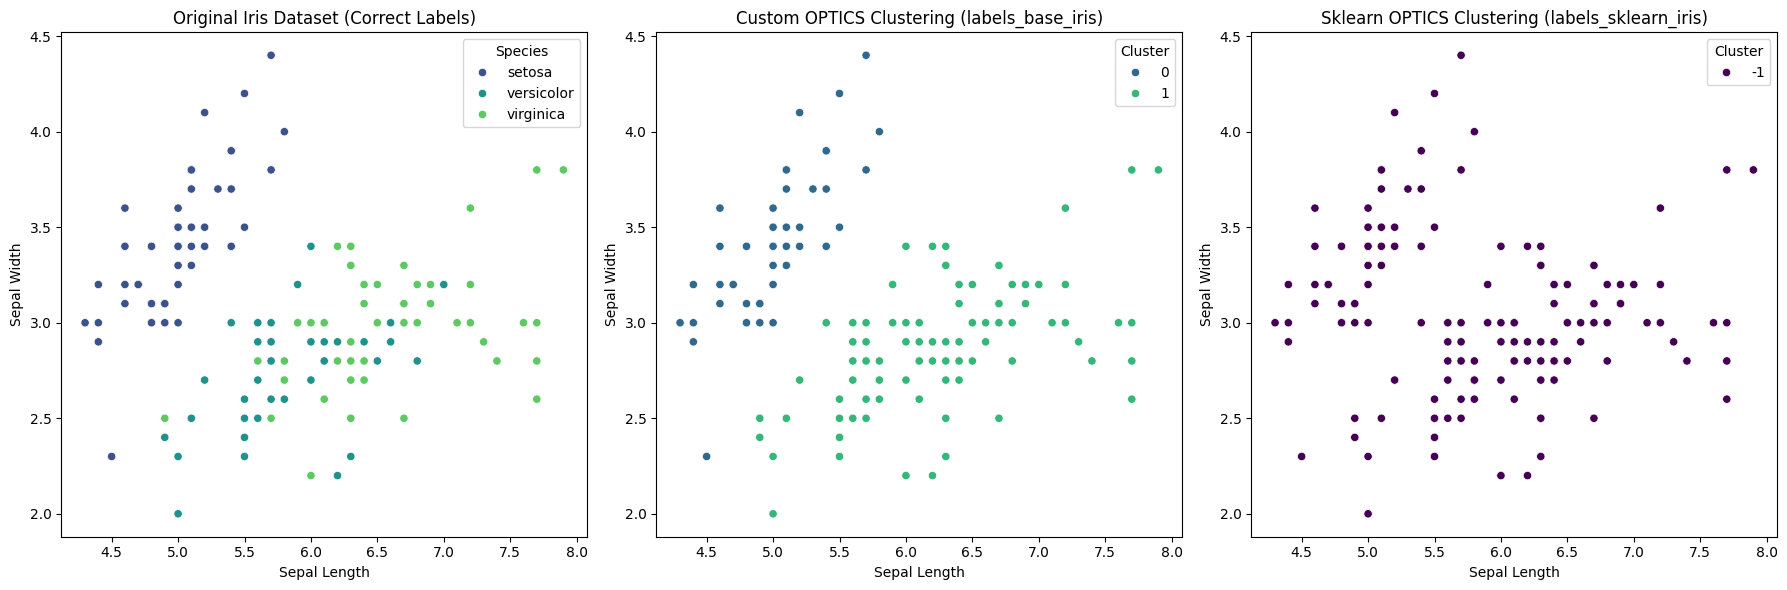

In [ ]:

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="viridis", ax=axes[0])
axes[0].set_title("Original Iris Dataset (Correct Labels)")
axes[0].set_xlabel("Sepal Length")
axes[0].set_ylabel("Sepal Width")
axes[0].legend(title="Species")

# Plot 2: Custom DBSCAN Labels (labels_base_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_base_iris_optics, palette="viridis", ax=axes[1])
axes[1].set_title("Custom OPTICS Clustering (labels_base_iris)")
axes[1].set_xlabel("Sepal Length")
axes[1].set_ylabel("Sepal Width")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_sklearn_iris_optics, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn OPTICS Clustering (labels_sklearn_iris)")
axes[2].set_xlabel("Sepal Length")
axes[2].set_ylabel("Sepal Width")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## AI


In [29]:
path = kagglehub.dataset_download("katerynameleshenko/ai-index")
ai = pd.read_csv(os.path.join(path, "AI_index_db.csv"))
ai = ai.dropna()

ai["Total_score_Category"] = pd.cut(
    ai["Total score"],
    bins=[-float("inf"), 17.03, 26.91, float("inf")],
    labels=["Low", "Medium", "High"]
)
ai = ai.drop(columns=["Total score"])

ai_filtered = ai.select_dtypes(include=['float64'])

# scaler_ai = StandardScaler()
X_ai = ai_filtered.to_numpy()
k_ai = 3

scalar = StandardScaler()
X_ai = scalar.fit_transform(X_ai)

print("AI Global Index")

start_time = time.time()
# labels_base_ai, centroids_base_ai = k_means(X_ai, k_ai)
# cluters, noise, labels_base_ai = dbscan_base(X_ai, 0.5, 5)

ordered_list, reachability_dist = optics_base(X_ai, np.inf, 5)
# labels_base_ai_optics = extract_clusters_manual(ordered_list, reachability_dist, 5)
labels_base_ai_optics = extract_clusters_dbscan(ordered_list, reachability_dist, 0.5, 5)

print(labels_base_ai_optics)
print(f"Execution time (base): {time.time() - start_time} seconds")
# print(f"Silhouette score (base): {silhouette_score(X_ai, labels_base_ai)}")
print_metrics(X_ai, ai['Total_score_Category'], labels_base_ai_optics)

start_time = time.time()

optics_ai = OPTICS(cluster_method="dbscan").fit(X_ai)

labels_sklearn_ai_optics = optics_ai.labels_
print(labels_sklearn_ai_optics)

print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_ai, ai['Total_score_Category'], labels_sklearn_ai_optics)

AI Global Index
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Execution time (base): 0.14513826370239258 seconds
-------------------------------------------------------------------
Silhouette score failed: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Adjusted Rand score: 0.0000
Calinski-Harabasz score failed: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Davies-Bouldin score failed: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Mutual Information score: 0.0000
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]

Execution time (sklearn): 0.1006619930267334 seconds
-------------------------------------------------------------------
Silhouette score failed: Number of labels is 1. Valid values are 2

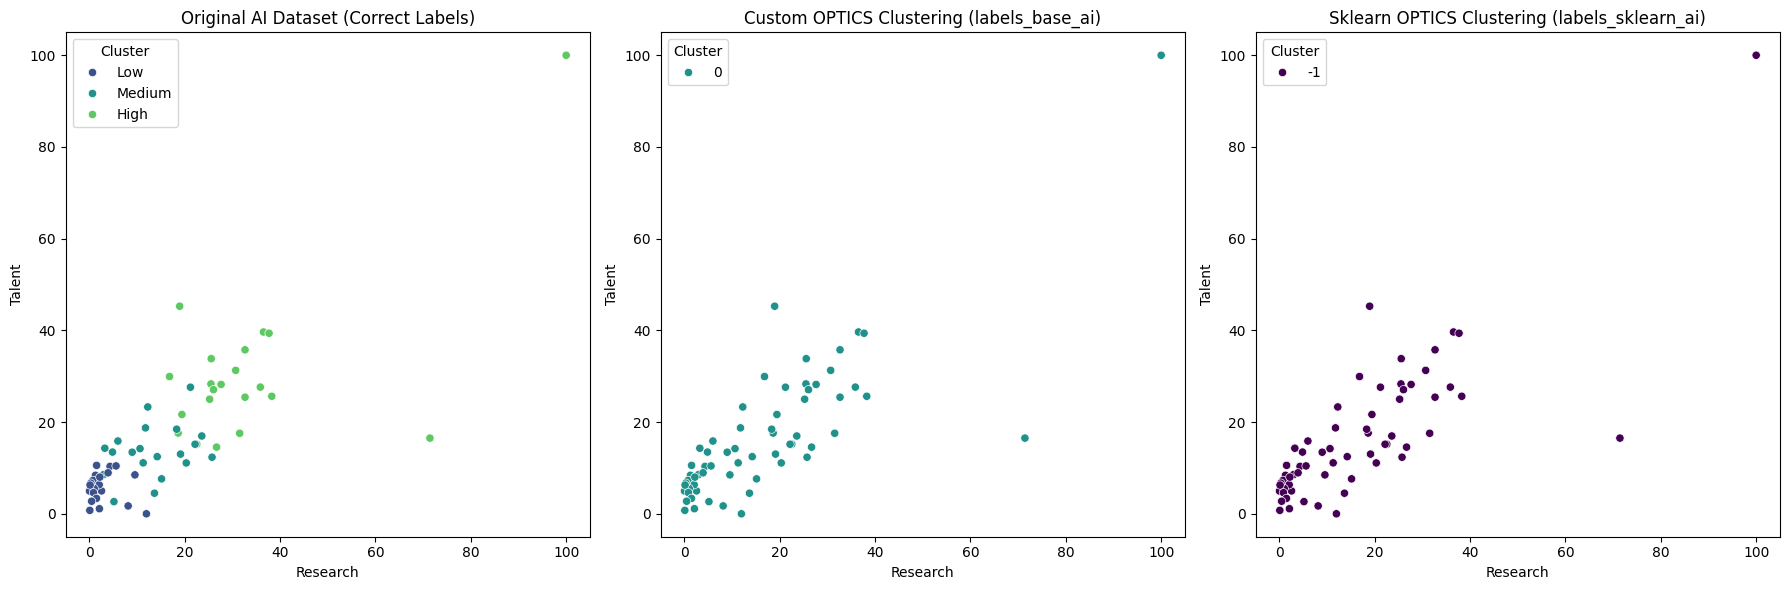

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[0])
axes[0].set_title("Original AI Dataset (Correct Labels)")
axes[0].set_xlabel("Research")
axes[0].set_ylabel("Talent")
axes[0].legend(title="Cluster")

# Plot 2: Custom OPTICS Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai_optics, palette="viridis", ax=axes[1])
axes[1].set_title("Custom OPTICS Clustering (labels_base_ai)")
axes[1].set_xlabel("Research")
axes[1].set_ylabel("Talent")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn OPTICS Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai_optics, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn OPTICS Clustering (labels_sklearn_ai)")
axes[2].set_xlabel("Research")
axes[2].set_ylabel("Talent")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Earthquakes


In [30]:
path = kagglehub.dataset_download("shreyasur965/recent-earthquakes")
earthquakes = pd.read_csv(os.path.join(path, "earthquakes.csv"))

earthquakes = earthquakes.drop(columns=["time", "updated", "timezone", "latitude", "longitude", "tsunami", "nst", "dmin", "gap", "distanceKM", "postcode"])
earthquakes_filtered = earthquakes.select_dtypes(include=['float64', 'int64'])

X_earth = earthquakes_filtered.to_numpy()
# k_earth = 4

print("Global Earthquake Data")

start_time = time.time()
# labels_base_earth, centroids_base_earth = k_means(X_earth, k_earth)
# cluters, noise, labels_base_earth = dbscan_base(X_earth, 0.5, 5)

ordered_list, reachability_dist = optics_base(X_earth, np.inf, 5)
# labels_base_earth_optics = extract_clusters_manual(ordered_list, reachability_dist, 5)
labels_base_earth_optics = extract_clusters_dbscan(ordered_list, reachability_dist, 0.5, 5)

print(labels_base_earth_optics)
print(f"Execution time (base): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes['alert'], labels_base_earth_optics)

start_time = time.time()

optics_earth = OPTICS(cluster_method="dbscan").fit(X_earth)
labels_sklearn_earth_optics = optics_earth.labels_
print(labels_sklearn_earth_optics)
print(f"\nExecution time (sklearn): {time.time() - start_time} seconds")
print_metrics(X_earth, earthquakes['alert'], labels_sklearn_earth_optics)

Global Earthquake Data
[ 0 -1  3 ... 25 -1 -1]
Execution time (base): 32.47916007041931 seconds
-------------------------------------------------------------------
Silhouette score: -0.5529
Adjusted Rand score: -0.0048
Calinski-Harabasz score: 0.1782
Davies-Bouldin score: 29.7993
Mutual Information score: 0.0531
[-1 -1 -1 ... -1 -1 -1]

Execution time (sklearn): 1.5241312980651855 seconds
-------------------------------------------------------------------
Silhouette score failed: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Adjusted Rand score: 0.0000
Calinski-Harabasz score failed: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Davies-Bouldin score failed: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Mutual Information score: 0.0000


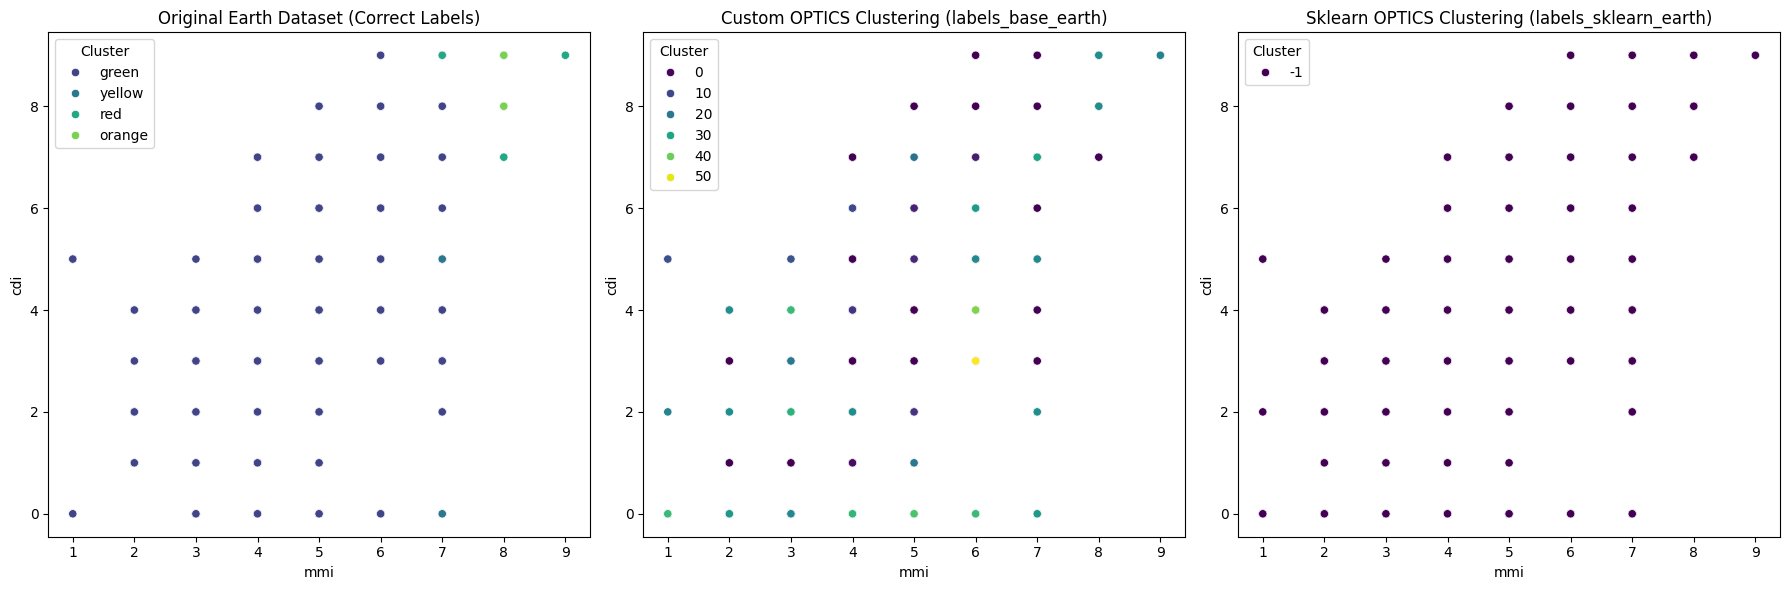

In [ ]:


import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette="viridis", ax=axes[0])
axes[0].set_title("Original Earth Dataset (Correct Labels)")
axes[0].set_xlabel("mmi")
axes[0].set_ylabel("cdi")
axes[0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_base_earth_optics, palette="viridis", ax=axes[1])
axes[1].set_title("Custom OPTICS Clustering (labels_base_earth)")
axes[1].set_xlabel("mmi")
axes[1].set_ylabel("cdi")
axes[1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_sklearn_earth_optics, palette="viridis", ax=axes[2])
axes[2].set_title("Sklearn OPTICS Clustering (labels_sklearn_earth)")
axes[2].set_xlabel("mmi")
axes[2].set_ylabel("cdi")
axes[2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

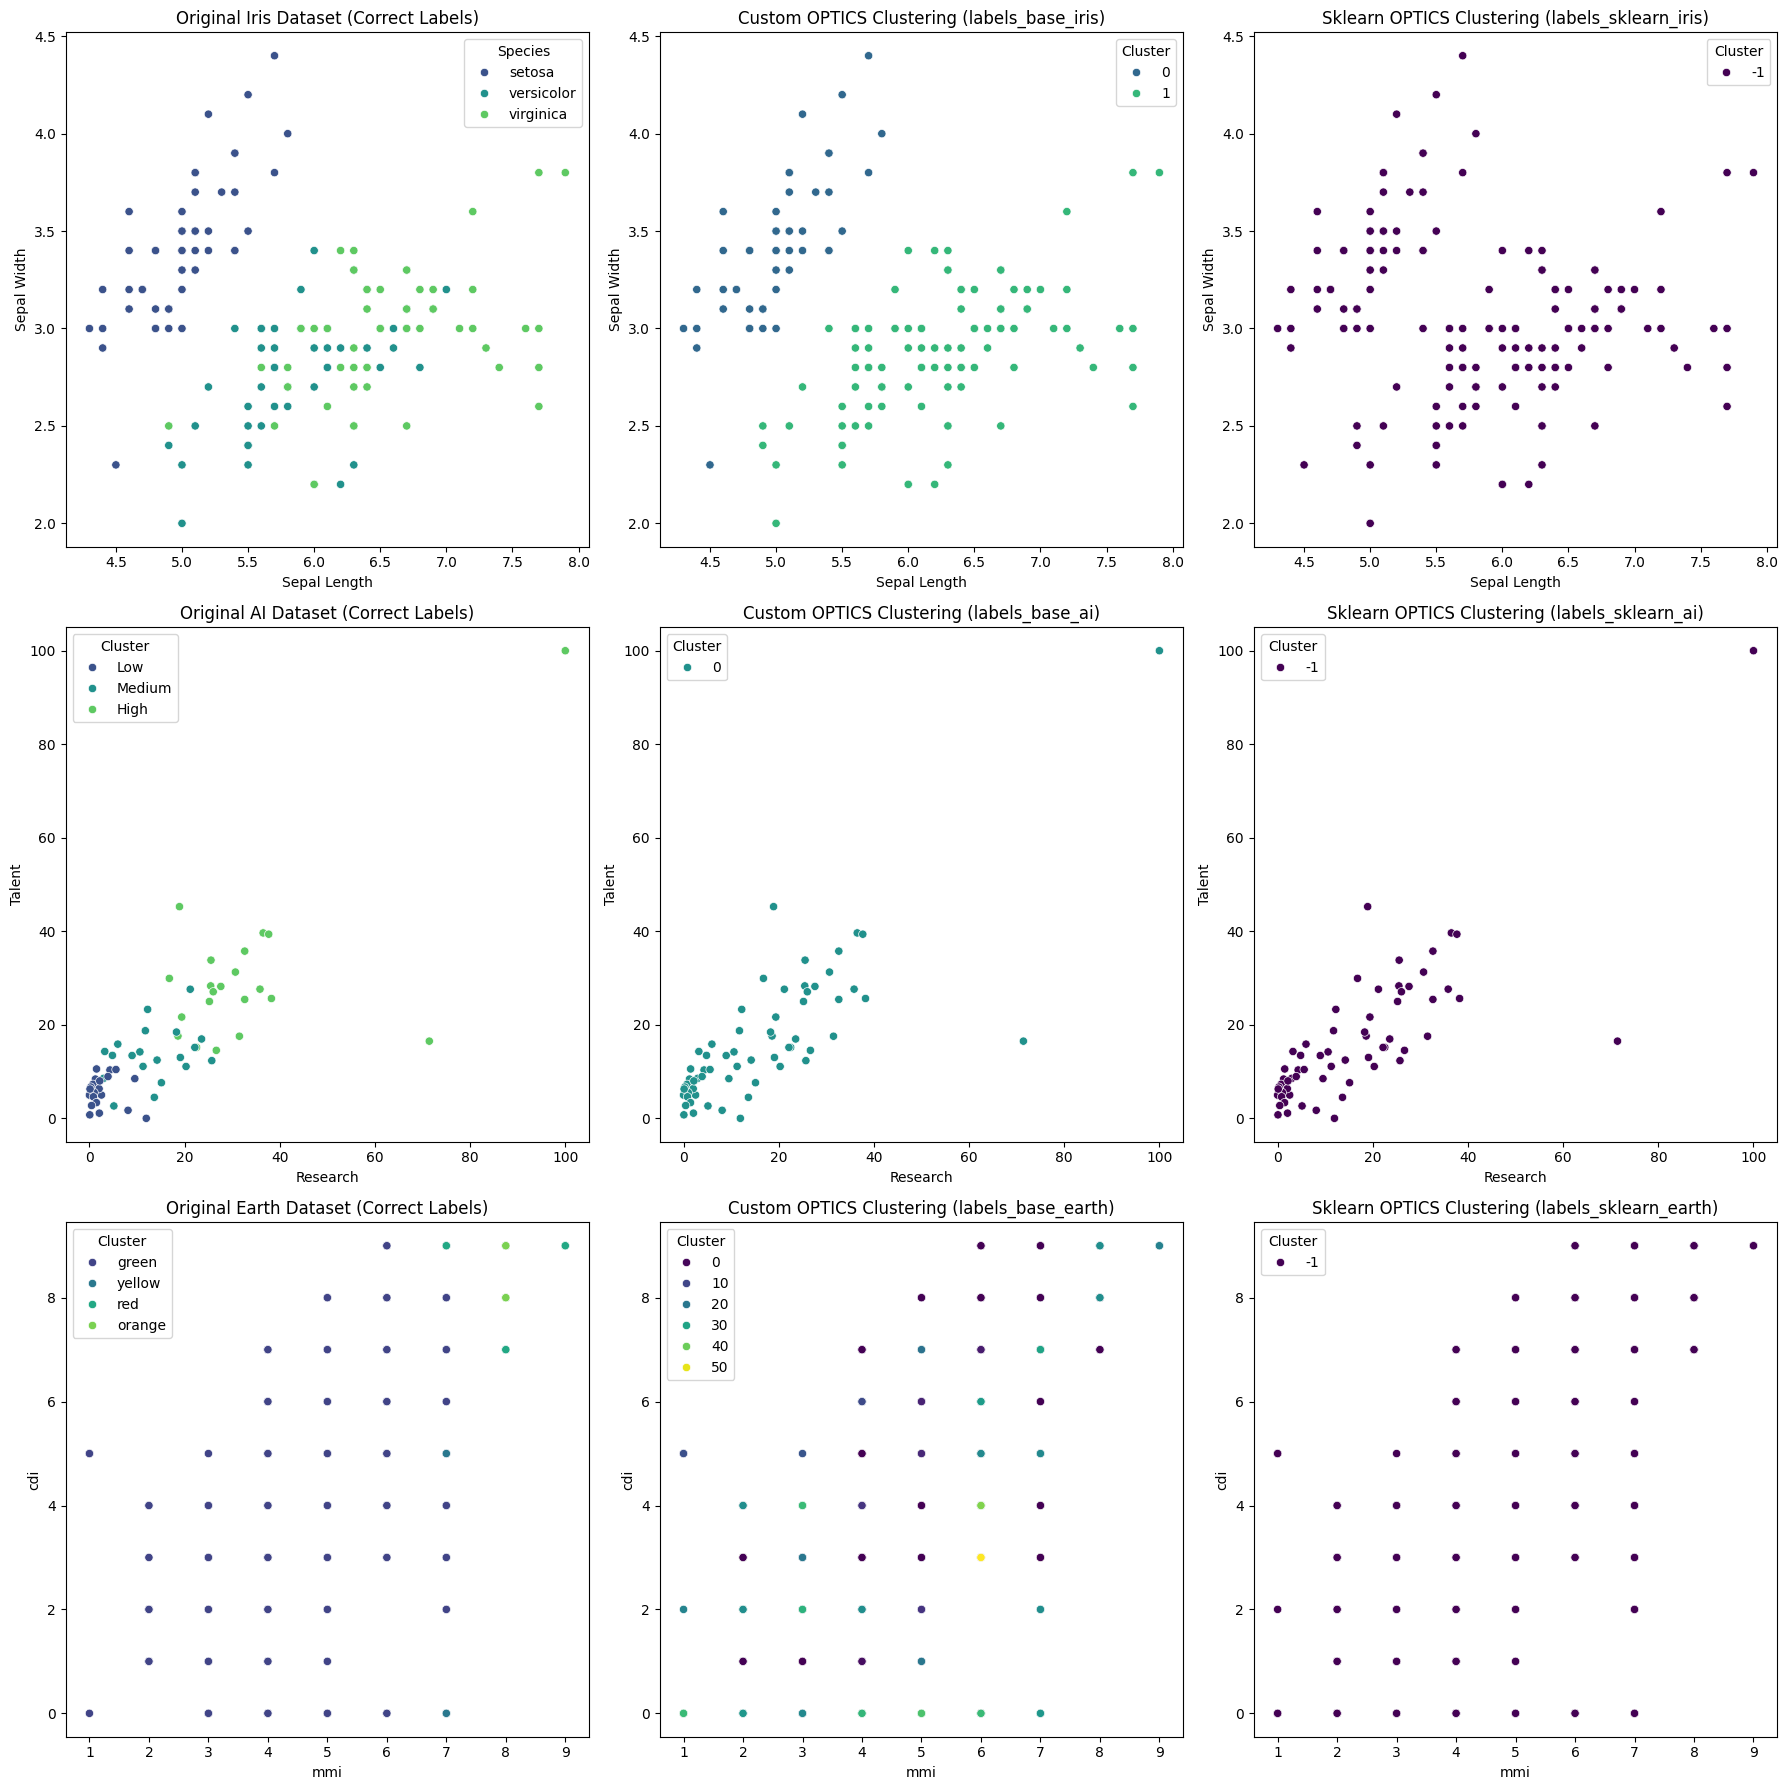

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with three subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue="species", palette="viridis", ax=axes[0][0])
axes[0][0].set_title("Original Iris Dataset (Correct Labels)")
axes[0][0].set_xlabel("Sepal Length")
axes[0][0].set_ylabel("Sepal Width")
axes[0][0].legend(title="Species")

# Plot 2: Custom DBSCAN Labels (labels_base_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_base_iris_optics, palette="viridis", ax=axes[0][1])
axes[0][1].set_title("Custom OPTICS Clustering (labels_base_iris)")
axes[0][1].set_xlabel("Sepal Length")
axes[0][1].set_ylabel("Sepal Width")
axes[0][1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="sepal_length", y="sepal_width", hue=labels_sklearn_iris_optics, palette="viridis", ax=axes[0][2])
axes[0][2].set_title("Sklearn OPTICS Clustering (labels_sklearn_iris)")
axes[0][2].set_xlabel("Sepal Length")
axes[0][2].set_ylabel("Sepal Width")
axes[0][2].legend(title="Cluster")

# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=ai, x="Research", y="Talent", hue="Total_score_Category", palette="viridis", ax=axes[1][0])
axes[1][0].set_title("Original AI Dataset (Correct Labels)")
axes[1][0].set_xlabel("Research")
axes[1][0].set_ylabel("Talent")
axes[1][0].legend(title="Cluster")

# Plot 2: Custom OPTICS Labels (labels_base_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_base_ai_optics, palette="viridis", ax=axes[1][1])
axes[1][1].set_title("Custom OPTICS Clustering (labels_base_ai)")
axes[1][1].set_xlabel("Research")
axes[1][1].set_ylabel("Talent")
axes[1][1].legend(title="Cluster")

# Plot 3: Sklearn OPTICS Labels (labels_sklearn_ai)
sns.scatterplot(data=ai, x="Research", y="Talent", hue=labels_sklearn_ai_optics, palette="viridis", ax=axes[1][2])
axes[1][2].set_title("Sklearn OPTICS Clustering (labels_sklearn_ai)")
axes[1][2].set_xlabel("Research")
axes[1][2].set_ylabel("Talent")
axes[1][2].legend(title="Cluster")


# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue="alert", palette="viridis", ax=axes[2][0])
axes[2][0].set_title("Original Earth Dataset (Correct Labels)")
axes[2][0].set_xlabel("mmi")
axes[2][0].set_ylabel("cdi")
axes[2][0].legend(title="Cluster")

# Plot 2: Custom DBSCAN Labels (labels_base_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_base_earth_optics, palette="viridis", ax=axes[2][1])
axes[2][1].set_title("Custom OPTICS Clustering (labels_base_earth)")
axes[2][1].set_xlabel("mmi")
axes[2][1].set_ylabel("cdi")
axes[2][1].legend(title="Cluster")

# Plot 3: Sklearn DBSCAN Labels (labels_sklearn_ai)
sns.scatterplot(data=earthquakes, x="mmi", y="cdi", hue=labels_sklearn_earth_optics, palette="viridis", ax=axes[2][2])
axes[2][2].set_title("Sklearn OPTICS Clustering (labels_sklearn_earth)")
axes[2][2].set_xlabel("mmi")
axes[2][2].set_ylabel("cdi")
axes[2][2].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()